In [1]:
%config InlineBackend.figure_format = "svg"

from pennylane import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pennylane as qml

# Grover algorithm with a Quantum Variational Circuit

In this notebook, the problem we will be solving is about using a variational circuit that implements Grover's algorithm. This will be done by using the `Pennylane` library, which natively implements both **parameter-shift rules** and more complex methods for **calculating gradients on quantum hardware**.

To do so, we will apply an ansatz $U(\theta)$ on the input quantum state $|{0}\rangle^{\otimes n}$, where $n$ represents the number of qubits in the quantum circuit.

The goal of Grover's search is to be able to find marked elements $|x^{\star}_k\rangle \in \mathcal{S}$, where $\mathcal{S} \subseteq \mathbb{C}^{2^n}$ and $x^{\star}_ k \in \{0,1\}^n$ is an $n$-bit string, where $n$ represents the number of qubits in our circuit. If we consider $G$ the operator that represents a **general** and **ideal** output of Grover's algorithm, then we can express it as:
$$ G |0\rangle^{\otimes n} = \frac{1}{\sqrt{|\mathcal{S}|}} \sum_{k=1}^{|\mathcal{S}|} e^{i\varphi_k} |x^{\star}_k\rangle = \sum_{k=1}^{n} |\psi\rangle_k $$

Such that the probability of measuring a final quantum state $| \psi \rangle_k$ is given by:

$$ P \left[ |\psi\rangle_k \right] = \frac{1}{|\mathcal{S}|}, \; \forall | \psi \rangle_k \in \mathcal{S} $$

$$ P \left[ |\psi\rangle_k \right] = 0, \; \forall | \psi_k \rangle \notin \mathcal{S} $$

With a Quantum Variational Circuit with $n$ qubits, where at the output we will have $n$ expectation values (one per qubit) $f_k(\theta) = {}_k\langle0| U^{\dagger}(\theta) Z U(\theta) |0\rangle_ k$ and $Z$ is the Pauli Z gate, we want the probabilites of each qubit to match the probability amplitude of the Grover's search solution. Then, we want the output of our QVC to obey the equation:

$$ \left| f_k(\theta) \right|^2 = P \left[ |\psi\rangle_k \right], \; k = \{1, 2, \dots, n\} $$

Therefore, to learn the parameters $\theta$ of our QVC, we can just minimize a simple _absolute difference loss_:

$$ \min_\theta \mathcal{L}(\theta) = \sum_{k=1}^{n} \left| \left| f_k(\theta) \right|^2 - P \left[ |\psi\rangle_k \right] \right| $$

## Defining model hyperparameters

In [2]:
# hyperpatameters of the circuit
nr_qubits = 8
target_qubits = np.array([1, 5, 7], requires_grad=False) 
nr_layers = 6

# define quantum device
dev = qml.device("default.qubit", wires=nr_qubits)

In [3]:
def normalize(vector):
    norm = np.sqrt(np.sum(vector**2))
    return vector / norm

def probabilities(vector):
    nvector = normalize(vector)
    return nvector * np.conj(nvector)

In [4]:
def combinations(values):
    """
    Calculates every possible pair combination of values
    """
    r = []
    for i in range(len(values)):
        for j in range(i+1,len(values)):
            r.append((i,j))
    return r

# a layer of the circuit ansatz
def layer(weights, j):
    for i in range(weights.shape[1]):
        qml.RX(weights[j, i, 0], wires=i)
        qml.RY(weights[j, i, 1], wires=i)
        qml.RZ(weights[j, i, 2], wires=i)

    # Add CNOT for every qubit combination
    combs = combinations(range(weights.shape[1]))
    for i, k in combs:
        if j % 2 == 1:
            i, k = k, i
        qml.CNOT(wires=[i, k])

@qml.qnode(dev)
def qvc(weights):
    # repeatedly apply each layer in the circuit
    for j in range(weights.shape[0]):
        layer(weights, j)

    # returns the expectation of the input matrix A on the first qubit
    measurements = [qml.expval(qml.PauliZ(i)) for i in range(weights.shape[1])]
    return measurements

# cost function
def loss_fn(prediction, label):
    """
    A simple square loss function to evaluate predictions
    """
    pred_prob = probabilities(prediction)
    label_prob = probabilities(label)
    loss = np.sum(np.abs(pred_prob - label_prob))
    return loss

In [5]:
# Define model parameters
weights = np.random.randn(nr_layers, nr_qubits, 3)

# Defining the target of the circuit's output
target = np.zeros(nr_qubits)
target[target_qubits-1] = 1

# Defining our model's optimizer
optimizer = qml.AdamOptimizer()

## Defining the training loop for our model

In [6]:
# Training loop
num_steps = 1000
fit_tqdm = tqdm(range(num_steps), total=num_steps, desc="Fitting the model")
for _ in fit_tqdm:
    loss = loss_fn(qvc(weights), target)
    weights = optimizer.step(lambda v: loss_fn(qvc(v), target), weights)
    fit_tqdm.set_postfix({"loss": loss.item()})

Fitting the model:   0%|          | 0/1000 [00:00<?, ?it/s]

## Results

Target Qubits: [1 5 7]


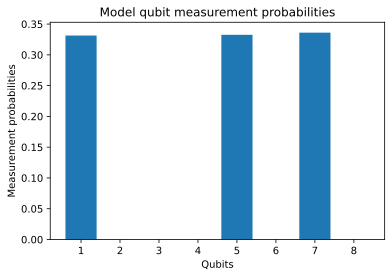

In [7]:
print(f"Target Qubits: {target_qubits}")
plt.title("Model qubit measurement probabilities")
plt.bar(range(1, nr_qubits+1), probabilities(qvc(weights)))
plt.xlabel("Qubits")
plt.ylabel("Measurement probabilities")
plt.show()